# Loan Defaults Modelling

The notebook aims to find the model that offers the best performance in __predicting loan defaults__. 

The primary metric used to evaluate model performance is the __F1 Score__, which is the harmonic mean between precision and recall. The rationale for choosing F1 is that we want to __identify as many defaults as possible while ensuring that our model is not over predicting the defaults__. Additionally, we will provide insgihts about the model performances in relation to its __precision__ and __recall__ and how different use cases may favour different models.

From our exploratory data analysis, we note that we are working with an __imbalanced dataset__. Therefore, we will be applying different __resampling techniques__ and monitor if there are improvements to the model's performance.

__Note__: The functions used in this notebook can be found in the scripts within the utils folder.

## Table of Contents <a id='table_contents'></a>

#### Machine Learning Models

* [Naive Model](#naive)
* [Nearest Centroid](#ncc) 
* [K-Nearest Neighbours](#knn)
* [Logistic Regression](#logreg)
* [Random Forest Classifier](#rforest)
* [Gradient Boosting Classifier](#gboost)

#### Resampling Methods

* [Random Over Sampling](#ros)
* [Synthetic Minority Over Sampling Technique](#smote)


#### Visualising Results

* [Feature Importance](#feature_importance)
* [Model Comparison](#compare_models)

#### Generating Predictions for Testing Data

* [Saving Predictions](#saving_params)

### Importing Libraries

In [1]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import pickle
import copy
warnings.filterwarnings('ignore')

# Custom Functions
from utils import visualisation as viz
from utils import modelling as mod

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

# Sampling Tools
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use('seaborn-muted')

# Misc
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%config InlineBackend.figure_formate = 'retina'

# Random State
SEED = 8888
np.random.seed(8888)

### Loading Our Processed Data

In [2]:
with open('training_cleaned.pickle', 'rb') as f:
    train = pickle.load(f)

with open('testing_cleaned.pickle', 'rb') as f:
    test = pickle.load(f)

### Splitting Data into Training and Testing Datasets

The dataset will be split into __training (80%)__ and __holdout (20%)__ datasets. 

__Model training and hyper paramter tuning__ will be performed using the training data and using __5-fold cross validation__. We will then compare the performance of different models on the holdout dataset.

In [3]:
X = train.drop('default_status', axis=1)
y = train.default_status

In [4]:
# stratified data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [5]:
# defining cross-validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [6]:
# kwargs for cross_validate method
cv_kwargs = {
    'scoring' : 'f1',
    'cv' : skf,
    'n_jobs' : -1,
    'return_train_score' : True,
    'verbose' : False,
    'return_estimator' : True
}

## Baseline Model : Nearest Centroid Classifier <a id='ncc'></a>

The Nearest Centroid Classifier is a simple algorithm that represents each class by the __centroid of its members__, similar to the label updating phase of the K-Means algorithm. Furthermore, there are __no parameters to choose from__, making it a __good baseline classifier__.

In [7]:
# ncc model pipeline
ncc_pipe = Pipeline(steps=[
    ('Standardise',  StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

Cross Validation Results Summary
Avg Training score 	 0.630980
Avg Testing score 	 0.624498

Avg Fitting Time 	 0.0056s
Avg Scoring Time 	 0.0020s


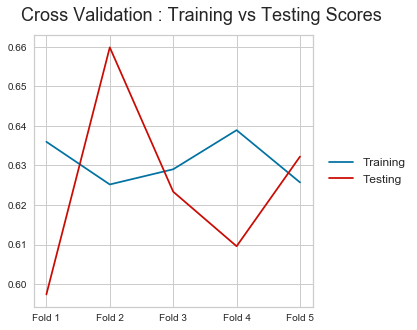

In [8]:
# cross validation summary report
ncc_cv_results = mod.cross_validation_summary(ncc_pipe, X_train, y_train, cv_kwargs, flip_scores=False)

Our baseline model has an __approximate 62% F1 Score__. We will save the estimator that performed the best during cross validation and test it on the holdout dataset.

Holdout Dataset Classification Report for Nearest Centroid
              precision    recall  f1-score   support

           0       0.86      0.67      0.76       326
           1       0.53      0.77      0.63       155

    accuracy                           0.70       481
   macro avg       0.69      0.72      0.69       481
weighted avg       0.75      0.70      0.71       481




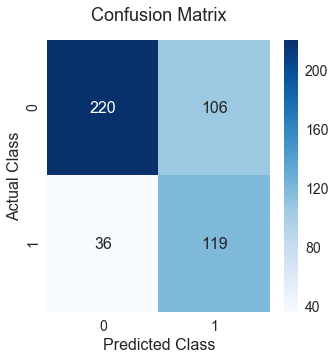

In [9]:
# saving best estimator from cross validation
ncc_model = mod.get_best_estimator(ncc_cv_results, greater_is_better=False)

# classification report for model on holdout data
ncc_y_pred = mod.holdout_evaluation(ncc_model, X_train, y_train, X_test, y_test, model_name='Nearest Centroid')

#### Model Performance Evaluation
The baseline model offers decent performance with with an __F1 score of 61%__. The model is also __decent at detecting loans that will default__, with a __recall of 77%__, but given the __low precision of 53%__, the model may be __over predicting defaults__. 

We will save the performance of our baseline and compare the results to other classification algorithms.

In [10]:
# saving model scores
ncc_results = mod.classification_scores(y_test, ncc_y_pred, model_name='NearestCentroid')
ncc_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263


In [11]:
# creating a results dataframe to compare models
model_results = ncc_results.copy(deep=True)

[Return to Table of Contents](#table_contents)

## K-Nearest Neighbours <a id='knn'></a>

KNN is a non-parametric method that assigns classes to observations based on the class majority of its k-nearest neighbours.

This model is also relatively simple to tune with __only one regularisation parameter k__, which is the number of neighbours to consider. 

However, as it is an instance-based learning techiques, it will be slower to evaluate predictions in production.

In [12]:
# creating dict of kwargs for GridSearchCV
gs_kwargs = dict((k, cv_kwargs[k]) for k in cv_kwargs if k != 'return_estimator')
gs_kwargs

{'scoring': 'f1',
 'cv': StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
 'n_jobs': -1,
 'return_train_score': True,
 'verbose': False}

In [13]:
# creating KNN model pipeline
knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

# KNN hyper parameters to iterate over
knn_param_grid = {
    'KNN__n_neighbors' : np.arange(2, 50, step=2),
}

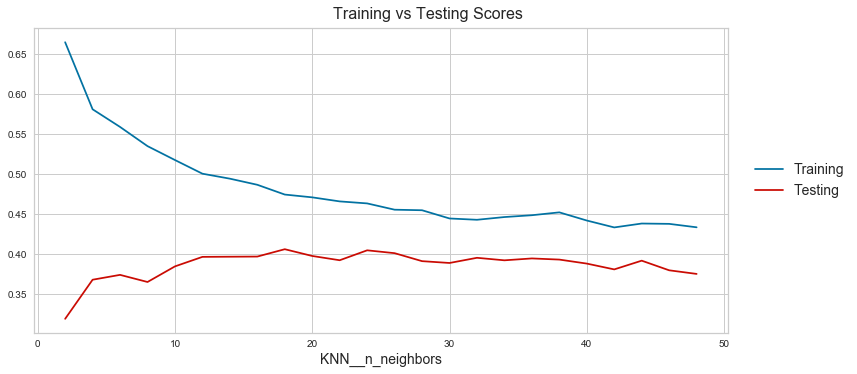

In [14]:
# average training and testing scores for KNN model for different hyper parameters 
mod.param_tuning_plots(knn_pipe, knn_param_grid, X_train, y_train, gs_kwargs, n_cols=1, figsize=(12,5))

#### Model Performance Interpretation
The figure shows that as `n_neighbours` start to increase beyound 25, the holdout performance deteriorates and the __model starts to overfit__. 

The optimal hyper parameter value appears to lie somewhere between 10 and 30 and we will iterate over this smaller range to find the best value.

In [15]:
# ppdated param gird with more hyper parameters
knn_param_grid = {
    'KNN__n_neighbors' : np.arange(10, 30, step=1),
    'KNN__weights' : ['uniform', 'distance'],
    'KNN__algorithm' : ['ball_tree', 'kd_tree', 'auto'],
    'KNN__metric' : ['euclidean', 'manhattan'],
    'KNN__n_jobs' : [-1]
}

In [16]:
# gridSearch to find the optimal hyper parameters 
knn_gscv = GridSearchCV(knn_pipe, knn_param_grid, **gs_kwargs)
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [17]:
# saving the best hyper parameters for KNN
knn_kwargs = dict((k[5:], knn_gscv.best_params_[k]) for k in knn_gscv.best_params_)
knn_kwargs

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_jobs': -1,
 'n_neighbors': 25,
 'weights': 'distance'}

Holdout Dataset Classification Report for Nearest Neighbours
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       326
           1       0.65      0.46      0.54       155

    accuracy                           0.75       481
   macro avg       0.71      0.67      0.68       481
weighted avg       0.73      0.75      0.73       481




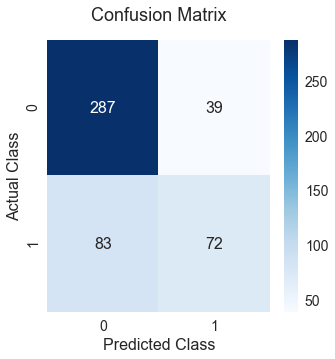

In [18]:
# saving best KNN estimator during GridSearch and evaluating on holdout data
knn_model = knn_gscv.best_estimator_
knn_y_pred = mod.holdout_evaluation(knn_model, X_train, y_train, X_test, y_test, model_name='Nearest Neighbours')

In [19]:
# saving KNN model performance on the holdout dataset
knn_results = mod.classification_scores(y_test, knn_y_pred, model_name='NearestNeighbour')

# appending results to results dataframe
model_results = model_results.append(knn_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414


#### Model Performance Interpretation
The K-Nearest Model has achieved an __F1 Score of 54%__, lower than the baseline model. We observe that the model has a __low recall of 46%__, which indicates that it is poor at identifying loans than will default. The model does have decent __precision of 65%__, which indicates that the predicted results are more reliable than the Nearest Centroid model.

[Return to Table of Contents](#table_contents)

## Logistic Regression <a id='logreg'></a>

Similar to the K-Nearest Neighbours model, the Logistic Regression also only has __one regularisation parameter lambda (C)__ to tune.

Furthermore, being a __parametric method__, it offers __great interpretability__ through analysing how the log-odds of default changes for each feature.

In [20]:
# creating logistic regression model and parameter grid to iterate over
logreg_kwargs = {
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

logreg_model = LogisticRegression(**logreg_kwargs)

logreg_param_grid = {
    'C' : np.logspace(-4,2,7)
}

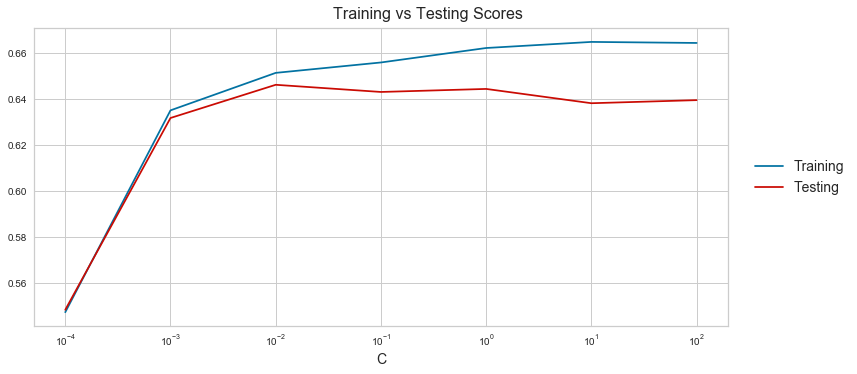

In [21]:
# average training and testing scores for different hyper parameter values
mod.param_tuning_plots(logreg_model, logreg_param_grid, X_train, y_train, gs_kwargs, n_cols=1,
                       x_axis_log_scale=True, figsize=(12,5))

The figure shows that as the as the regularisation parameter C increases to __greater than 1, the model starts to overfit__. 

__The optimal C appears to be somewhere around 0.01__. It seems that applying greater regularisation improves the model performance. We have narrowed our search space and will use a gridsearch to determine the optimal hyper parameter value.

In [22]:
# range of Cs to iterate over
logreg_param_grid = {
    'C' : np.arange(0.001, 0.1, step=0.002)
}

In [23]:
# gridsearch to find the optimal regularisation parameter C
logreg_gscv = GridSearchCV(logreg_model, logreg_param_grid, **gs_kwargs)
logreg_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8888, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='dep...
             param_grid={'C': array([0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017,
       0.019, 0.021, 0.023, 0.025, 0.027, 0.029, 0.031, 0.033, 0.035,
       0.037, 0.039, 0.041, 0.043, 0.045, 0.047, 0.049, 0.051, 0.053,
       0.055, 0.057, 0.059, 0.061, 0.063, 0.065, 0.067

In [24]:
# updating our logisitc regression kwargs
logreg_kwargs['C'] = logreg_gscv.best_params_['C']
logreg_kwargs

{'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'max_iter': 1000,
 'n_jobs': -1,
 'random_state': 8888,
 'C': 0.013000000000000001}

Holdout Dataset Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       326
           1       0.53      0.75      0.63       155

    accuracy                           0.71       481
   macro avg       0.69      0.72      0.69       481
weighted avg       0.75      0.71      0.72       481




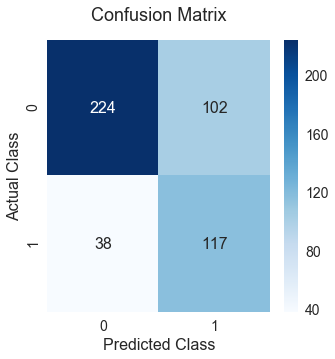

In [25]:
# saving the best estimator during GridSearch and getting evaluating on holdout data
logreg_model = logreg_gscv.best_estimator_
logreg_y_pred = mod.holdout_evaluation(logreg_model, X_train, y_train, X_test, y_test, model_name='Logistic Regression')

In [26]:
logreg_results = mod.classification_scores(y_test, logreg_y_pred, model_name='LogisticRegression')
model_results = model_results.append(logreg_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257


#### Model Performance Interpretation

The Logistic Regression has achieved an __F1 Score of 63%__, as well as similar precision and recall scores to the Baseline Nearest Centroid model.

Currently, the simpler Nearest Centoid model is performing the best out of the models we have tested but the results are not quite satisfactory yet. 

We will move on to trying more complex models.

[Return to Table of Contents](#table_contents)

## Random Forest Classifier <a id='rforest'></a>

Random Forests have much more parameters to tune as compared to the previous models.

Firstly, we will evaluate the performance of a Random Forest model with __default parameter values__. This provides us a __benchmark__ to compare our tuned random forest later on.

The hyper parameters that we are mainly concerned with are those that help __regularise__ the model. These are primarily parameters that affect __how our trees are grown__, such as: 

* `max_depth` : Maximum depth the tree is grown
* `max_features` : Number of features to select when building each individual tree
* `min_samples_split` : Minimum number of samples within a node to continue growing the tree
* `min_samples_leaf` : Minimum number of samples required to be at a leaf node 

### Untuned Random Forest

In [27]:
# baseline random forest parameters
rforest_kwargs = {
    'n_estimators' : 100,
    'criterion' : 'gini',
    'class_weight' : 'balanced',
    'bootstrap' : True,
    'n_jobs' : -1,
    'random_state' : SEED
}

# creating default random forest model
baseline_rforest = RandomForestClassifier(**rforest_kwargs)

Holdout Dataset Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       326
           1       0.87      0.63      0.73       155

    accuracy                           0.85       481
   macro avg       0.86      0.79      0.81       481
weighted avg       0.85      0.85      0.84       481




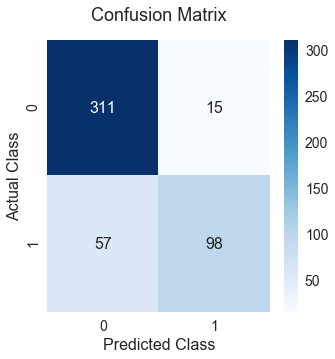

In [28]:
# performance report for untuned random forest
baseline_rforest_y_pred = mod.holdout_evaluation(baseline_rforest, X_train, y_train, X_test, y_test,
                                                 model_name='Random Forest')

In [29]:
baseline_rforest_results = mod.classification_scores(y_test, baseline_rforest_y_pred, model_name='UntunedRForest')
model_results = model_results.append(baseline_rforest_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313


#### Model Performance Interpretation

The baseline Random Forest Model has __greatly outperformed__ the other models with an __F1 Score of 73%__.

While it has a lower recall than some of the other models, the high precision of around 87% means we care more confident of the positive predictions.

It must also be noted that the earlier models were over predicting the positive classes.

Next, we will __tune the regularisation parameters__ in hopes of improving the model performance.

### Tuning Random Forest Parameters

As there are alot of regularisation paramters to tune, i like to look at __how the training and test scores changes during cross validation__ as we iterate through a range of values for each individual hyper parameter.

This gives me a sense of what range of values to search through and allow me to __fit a smaller range of values to iterate over during the GridSearch__. This reduces the search space and greatly saves on computation time.

In [30]:
# hyper parameters and their respective search space
rforest_param_grid = {
    'max_features' : ['sqrt', 'log2'],
    'max_depth' : np.arange(2,31,step=2),
    'min_samples_split' : np.arange(2,100,step=4),
    'min_samples_leaf' : np.arange(1,50,step=3)
}

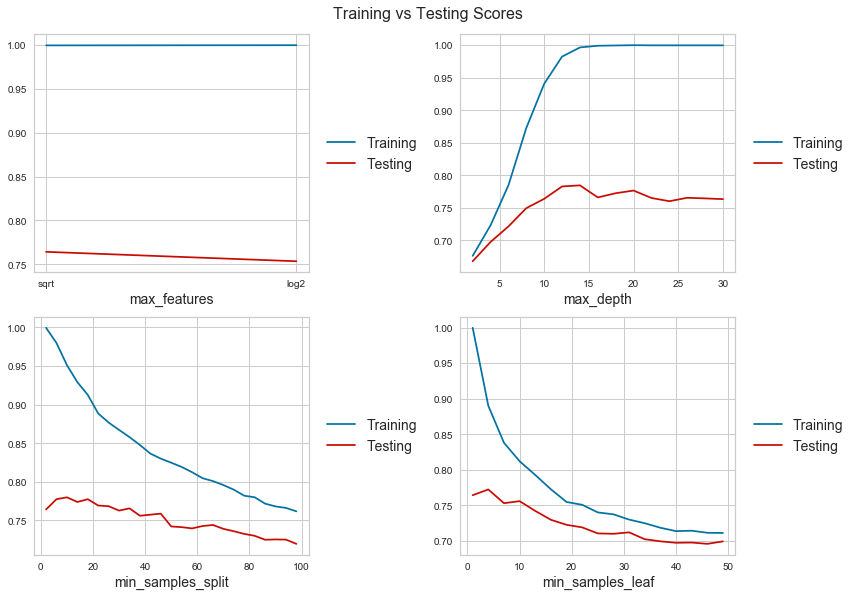

In [31]:
mod.param_tuning_plots(baseline_rforest, rforest_param_grid, X_train, y_train, gs_kwargs, n_cols=2,
                       x_axis_log_scale=False, figsize=(12,8))

#### Observations from Training and Testing Scores

1. The optimal `max_features` to be considered at each split appears to be using the square root of total number of features. 
2. For `max_depth`, the optimal depth appears to be __between 10 and 25__. Beyond 25, the model starts to __overfit__.
3. For the `minimum samples to split`, the optimal number of samples seems to be __between 2 and 20 samples per node__. Beyond 20, the model performance deteriorates.
4. For `minimum samples per leaf`, the optimal number of samples seems to be __between 1 to 10 samples per leaf__. 

We now have a smaller search space to find the optimal parameters using a GridSearch.

In [32]:
# Updating our hyper parameter search space
rforest_param_grid = {
    'max_features' : ['sqrt'],
    'max_depth' : np.arange(10, 26, step=1),
    'min_samples_split' : np.arange(10,21,step=1),
    'min_samples_leaf' : np.arange(1,11,step=1)
}

In [33]:
# gridsearch with updated hyper parameter search space
rforest_gscv = GridSearchCV(baseline_rforest, rforest_param_grid, **gs_kwargs)
rforest_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_spl...
                                              random_state=8888, verbose=0,
                                              warm_start=False),
             iid='deprecated', n_jobs=-1,
        

In [34]:
rforest_kwargs.update(rforest_gscv.best_params_)
rforest_kwargs

{'n_estimators': 100,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True,
 'n_jobs': -1,
 'random_state': 8888,
 'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

Holdout Dataset Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       326
           1       0.82      0.70      0.76       155

    accuracy                           0.85       481
   macro avg       0.84      0.81      0.83       481
weighted avg       0.85      0.85      0.85       481




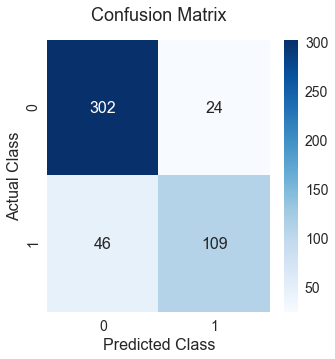

In [35]:
# saving the best estimator during GridSearch and evaluating on holdout data
rforest_model = rforest_gscv.best_estimator_
rforest_y_pred = mod.holdout_evaluation(rforest_model, X_train, y_train, X_test, y_test, model_name='Random Forest')

In [36]:
rforest_results = mod.classification_scores(y_test, rforest_y_pred, model_name='RandomForest')
model_results = model_results.append(rforest_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313
4,RandomForest,0.8545,0.8148,0.8195,0.7032,0.7569


#### Model Performance Interpretation

__After tuning__ our Random Forest model, the __F1 Score has improved slightly by about 2.5% from the untuned model__ and currenlty is the best performing model with an F1 of 76%. The tuned Random Forest has a __lower precision but higher recall then the untuned model__. 

The __advantage__ of the tuned Random Forest model is that it offers the __best overall performance__ in terms of __correctly identifying defaults__ (recall) and __how reliable the predicted results are__ (precision). It does not have as high recall as the Nearest Centroid or Logistic Regression, but the results are much more reliable. 

As for the untuned Random Forest model, it still remains the model with the highest reliability (precision), which could be useful for a different use case.

[Return to Table of Contents](#table_contents)

## Gradient Boosting Classifier <a id='gboost'></a>

Gradient Boosted Trees are similar to Random Forests as they are both __ensembles learning methods__ that operate by constructing a multitude of decision trees. The difference is that gradient boosting combines weak learners (low depth decision trees) into a single strong learner by sequentially fitting the residual of each weak learner into the next until a stopping criteria is met. 

As it is an ensemble of decision trees as well, it shares alot of the regularisation parameters with Random Forests. However, there are a few more parameters such as `learning_rate`, `tol` (tolerance) and `n_iter_no_change` (stopping criteria) that need to be tuned for the best results.

In [37]:
# default gradient boosting kwargs
gboost_kwargs = {
    'learning_rate' : 0.1,
    'n_estimators' : 100,
    'subsample' : 1.0,
    'criterion' : 'mse',
    'min_samples_split' : 2,
    'min_samples_leaf' : 1,
    'random_state': SEED,
    'max_features' : None,
    'verbose' : 0,
    'validation_fraction' : 0.1,
    'n_iter_no_change' : None,
    'ccp_alpha' : 0.0
}

baseline_gboost = GradientBoostingClassifier(**gboost_kwargs)

Holdout Dataset Classification Report for UntunedGBoost
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       326
           1       0.85      0.68      0.76       155

    accuracy                           0.86       481
   macro avg       0.86      0.81      0.83       481
weighted avg       0.86      0.86      0.85       481




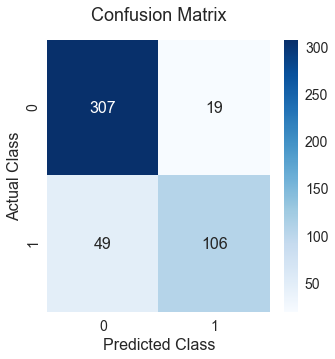

In [38]:
# classification report for untuned gradient boosting model
baseline_gboost_y_pred = mod.holdout_evaluation(baseline_gboost, X_train, y_train, X_test, y_test,
                                                model_name='UntunedGBoost')

In [39]:
baseline_gboost_results = mod.classification_scores(y_test, baseline_gboost_y_pred, model_name='UntunedGBoost')
model_results = model_results.append(baseline_gboost_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313
4,RandomForest,0.8545,0.8148,0.8195,0.7032,0.7569
5,UntunedGBoost,0.8586,0.8128,0.8480,0.6839,0.7571


#### Model Performance Interpretation

__The untuned Gradient Boosting model just barely edged out the tuned Random Forest model in terms of F1 score__.

In comparison to the tuned Random Forest model, it is slightly worse at detecting the postitive class but has a higher reliability for its predictions. 

However, the Gradient Boosting model still has a __lower precision than the Untuned Random Forest__. 

### Tuning Gradient Boosting Parameters

The methodology used for tuning the hyper parameters for the gradient boosting model have been adopted and modified from [this article][1]. 

First, we determine a small learning rate (<=0.1) and instead of choosing a fixed number of estimators to train on, we choose the number of estimators through early stopping.  

Therefore, we __increased the maximum number of trees the model can build__, in our case, __from the default of 100 to 1000__. However, building too many trees would cause the model to overfit, thus we need to __find an optimal stopping criteria__ for our model to know when to stop building more trees. 

The early stopping criteria `n_iter_n_change` is the number of __consecutive iterations whereby the accuracy score in the validation score does not improve by a certain amount__ (tolerance). The higher the number the more trees will be built, as it is harder to meet the early stopping criteria, and may cause the model to miss the inflection point.

Smaller learning rates in general provide better results as the expense of computational power, as more trees would be built before reaching the stopping criteria. Therfore, we have chosen a __learning rate of 0.1__ as it offers a good balance between robust results and computational intensity.

[1]: https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

In [40]:
# updating our Gradient Boosting paramters 
gboost_kwargs.update({'n_estimators' : 1000})

# Instantiating a new model
gboost = GradientBoostingClassifier(**gboost_kwargs)

In [41]:
# setting a range of early stopping values 
gboost_param_grid = {
    'n_iter_no_change' : np.arange(5,31,step=5)
}

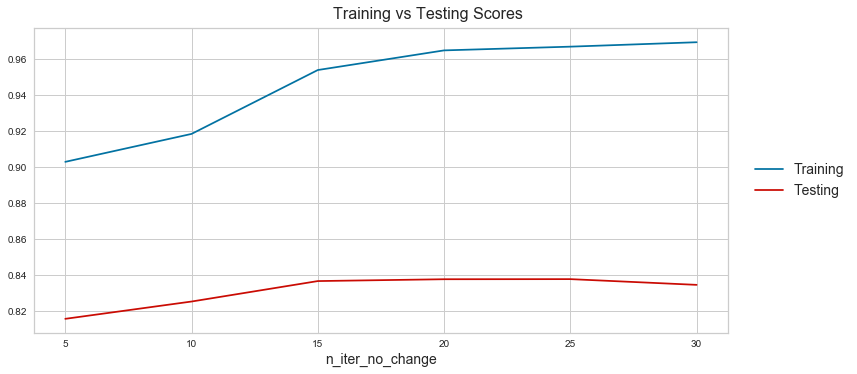

In [42]:
mod.param_tuning_plots(gboost, gboost_param_grid, X_train, y_train, gs_kwargs,
                       n_cols=1, x_axis_log_scale=False, figsize=(12,5))

#### Determining Stopping Criteria

From the figure, there performance of the model between 15 to 25 remains largely the same, and as we increase `n_iter_no_change` beyond 25, we may be missing the inflection point. Therefore, a __stopping criteria of 20__ iterations with no significant change in score seems appropriate.

In [43]:
# updating our GBoost kwargs for the stopping criterion
gboost_kwargs.update({'n_iter_no_change' : 20})

# Instantiating a new GBoost model
gboost = GradientBoostingClassifier(**gboost_kwargs)

In [44]:
# Range of values to iterate over for each hyper parameter
gboost_param_grid = {
    'max_depth' : np.arange(2, 10, step=1),
    'subsample' : np.arange(0.2, 1.1, step=0.1),
    'min_samples_split' : np.arange(2, 60, step=4),
    'min_samples_leaf' : np.arange(1, 50, step=3),
}

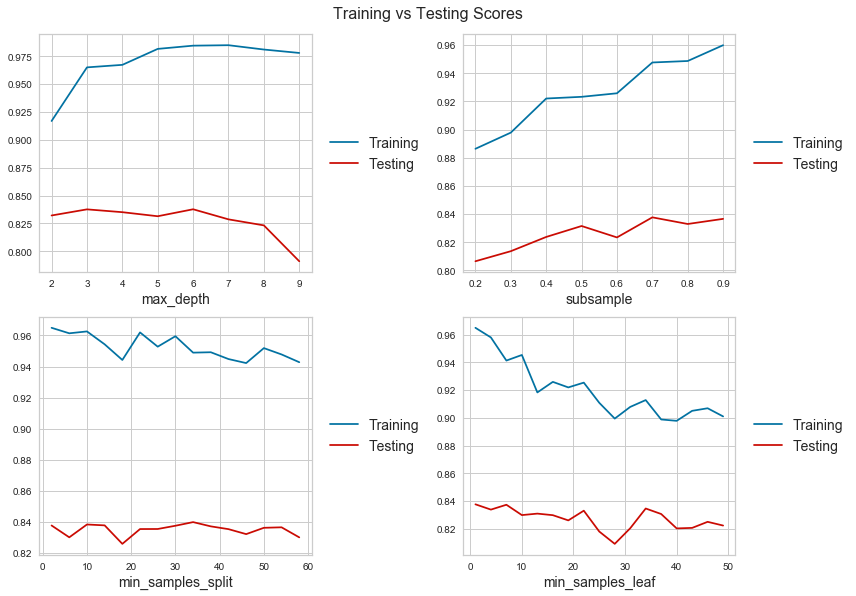

In [45]:
# lotting the training and testing scores as we iterate through different values for each parameter
mod.param_tuning_plots(gboost, gboost_param_grid, X_train, y_train, gs_kwargs,
                       n_cols=2, x_axis_log_scale=False, figsize=(12,8))

#### Observations from Training and Testing Scores

1. As the `maximum depth` that the tree is grown __increases beyond 6__, the model starts to __overfit__. The __optimal depth should be between 2 and 6__.
2. The parameter `subsample` is the proportion of samples used for fitting the model. A __sample proportion between 70% and 100%__ appears to give the best results.
3. For the `minimum samples to split` at each node, it the optimal value may lie somewhere __between 25 to 40__.
4. As for the `minimum samples per leaf node`, values greater than 10 do not offer much performance gain. __The optimal number should be below 10__.

In [46]:
# updating our hyper parameter search space
gboost_param_grid = {
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' : np.arange(2, 8, step=1),
    'subsample' : [0.65,0.70,0.75,0.90,0.95,1.0],
    'min_samples_split' : np.arange(25, 40, step=2),
    'min_samples_leaf' : np.arange(1,10, step=1)
}

In [47]:
# grid search for the optimal hyper parameters
gboost_gscv = GridSearchCV(gboost, gboost_param_grid, **gs_kwargs)
gboost_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='mse', init=None,
                                                  learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weigh...
                                                  verbose=0, warm_start=False),
             iid='deprec

In [48]:
# optimal Gradient Boosting hyper parameters
gboost_kwargs.update(gboost_gscv.best_params_)
gboost_kwargs

{'learning_rate': 0.1,
 'n_estimators': 1000,
 'subsample': 0.75,
 'criterion': 'mse',
 'min_samples_split': 35,
 'min_samples_leaf': 3,
 'random_state': 8888,
 'max_features': None,
 'verbose': 0,
 'validation_fraction': 0.1,
 'n_iter_no_change': 20,
 'ccp_alpha': 0.0,
 'max_depth': 5}

Holdout Dataset Classification Report for TunedGBoost
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       326
           1       0.88      0.74      0.80       155

    accuracy                           0.88       481
   macro avg       0.88      0.84      0.86       481
weighted avg       0.88      0.88      0.88       481




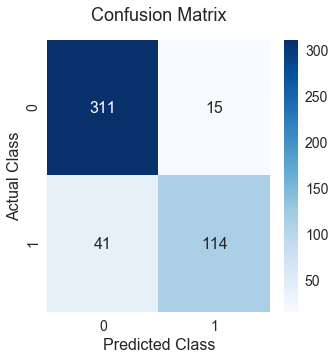

In [49]:
# saving the best estimator during GridSearch and evaluating on holdout data
tuned_gboost = gboost_gscv.best_estimator_
gboost_y_pred = mod.holdout_evaluation(tuned_gboost, X_train, y_train, X_test, y_test, model_name='TunedGBoost')

In [50]:
gboost_results = mod.classification_scores(y_test, gboost_y_pred, model_name='TunedGBoost')
model_results = model_results.append(gboost_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313
4,RandomForest,0.8545,0.8148,0.8195,0.7032,0.7569
5,UntunedGBoost,0.8586,0.8128,0.8480,0.6839,0.7571
6,TunedGBoost,0.8836,0.8447,0.8837,0.7355,0.8028


#### Model Performance Interpretation

Tuning the hyper parameters have markedly improved the baseline Gradient Boosting model. After tuning, the Gradient Boosting model has the __best F1 Score at 80%__.

The model has __highest precision__ as well as the __third highest recall__. Therefore, it is profficient at both identifying the positive class and the predicted results are reliable.

Therefore, the final model that we will be using to make predictions will be the Tuned Gradient Boosting model.

[Return to Table of Contents](#table_contents)

## Oversampling Minority Class <a id='oversampling'></a>

Now that we have selected our final model, we want to see if we can further improve our predictions through __resampling our data__.

Our dataset is imbalanced with 32% of observations are loans that defaulted. As our dataset is relatively small at 2400 observations, we will apply to following over sampling methods and observe if they improve our model results.

1. Random Over Sampling (ROS)
2. Synthetic Minority Over Sampling (SMOTE)

### Random Over Sampling Gradient Boosting <a id='ros'></a>

After resampling our data, we need to retrain our model to determine the optimal paramters.

However, we will be keeping the stopping criteria and learning rate that we have applied previously.

In [51]:
# default GBoost parameters updated with 1000 estimators and stopping criteria found earlier
baseline_gboost_kwargs= {
    'learning_rate' : 0.1,
    'n_estimators' : 1000,
    'subsample' : 1.0,
    'criterion' : 'mse',
    'min_samples_split' : 2,
    'min_samples_leaf' : 1,
    'max_depth' : 3,
    'random_state' : SEED,
    'max_features' : None,
    'verbose' : 0,
    'validation_fraction' : 0.1,
    'n_iter_no_change' : 20,
    'ccp_alpha' : 0.0
}

In [52]:
# instantiating the resampling transformer
ros = RandomOverSampler(random_state=SEED)

# creating a new Random Over Sampled GBoost pipeline
ros_gboost_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('GBoost', GradientBoostingClassifier(**baseline_gboost_kwargs))
])

In [53]:
# range of values to iterate over for each hyper parameter
ros_gboost_param_grid = {
    'GBoost__max_depth' : np.arange(2, 10, step=1),
    'GBoost__subsample' : np.arange(0.5, 1.1, step=0.1),
    'GBoost__min_samples_split' : np.arange(2, 60, step=4),
    'GBoost__min_samples_leaf' : np.arange(1, 50, step=3),
}

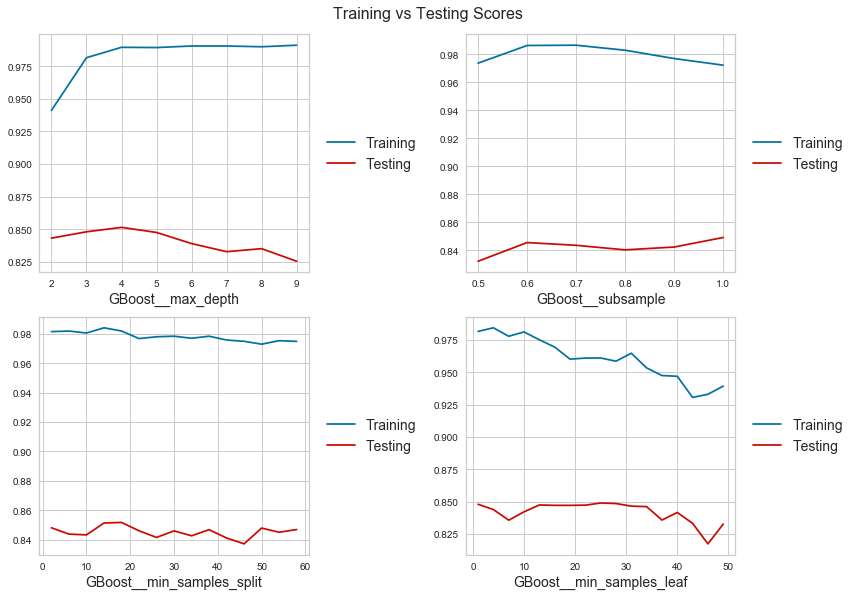

In [54]:
# plotting the training and testing scores as we iterate through different values for each parameter
mod.param_tuning_plots(ros_gboost_pipe, ros_gboost_param_grid, X_train, y_train, gs_kwargs,
                       n_cols=2, x_axis_log_scale=False, figsize=(12,8))

#### Observations from Training and Testing Scores

1. The model starts to __overfit__ as `maximum depth` __increases past 45__. The __optimal depth should be between 3 and 6__.
2. After resampling our data, it appears that the __sampling 60-70%__ of our data provides __similar performance to not sampling our data at all__. 
3. For the `minimum samples to split` at each node, it the optimal value may lie somewhere __between 10 to 20__.
4. As for the `minimum samples per leaf node`, the __default value of 1 appears to offer the best performance__. The optimal value seems to be __less than 5__.

From these observations, we can create a new subspace for our Grid Search.

In [55]:
# updating our search space
ros_gboost_param_grid = {
    'GBoost__max_depth' : np.arange(3, 7, step=1),
    'GBoost__subsample' : [0.60, 0.65, 0.70, 0.75, 1.0],
    'GBoost__min_samples_split' : np.arange(10, 20, step=1),
    'GBoost__min_samples_leaf' : np.arange(1, 6, step=1),
    'GBoost__max_features' : ['sqrt', None]
}

In [56]:
# grid Search for the optimal hyper parameters
ros_gboost_gscv = GridSearchCV(ros_gboost_pipe, ros_gboost_param_grid, **gs_kwargs)
ros_gboost_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('RandomOverSampler',
                                        RandomOverSampler(random_state=8888,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('GBoost',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='devi...
            

In [57]:
# optimal paramters for the ROS GBoost model
optimal_ros_params = dict((k[8:], ros_gboost_gscv.best_params_[k]) for k in ros_gboost_gscv.best_params_)
ros_gboost_kwargs = copy.deepcopy(baseline_gboost_kwargs)
ros_gboost_kwargs.update(optimal_ros_params)
ros_gboost_kwargs#### Evaluating ROS effects on our Gradient Boosting Model

{'learning_rate': 0.1,
 'n_estimators': 1000,
 'subsample': 0.75,
 'criterion': 'mse',
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_depth': 4,
 'random_state': 8888,
 'max_features': None,
 'verbose': 0,
 'validation_fraction': 0.1,
 'n_iter_no_change': 20,
 'ccp_alpha': 0.0}

#### Evaluating ROS effects on our Gradient Boosting Model

Holdout Dataset Classification Report for ROSTunedGBoost
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       326
           1       0.88      0.77      0.82       155

    accuracy                           0.89       481
   macro avg       0.89      0.86      0.87       481
weighted avg       0.89      0.89      0.89       481




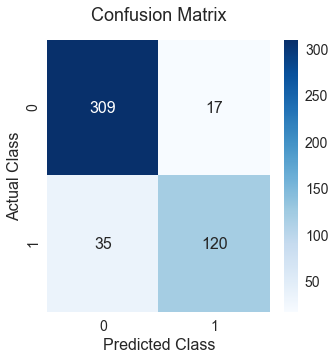

In [58]:
ros_tuned_gboost = ros_gboost_gscv.best_estimator_
ros_gboost_y_pred = mod.holdout_evaluation(ros_tuned_gboost, X_train, y_train, X_test, y_test, model_name='ROSTunedGBoost')

In [59]:
ros_gboost_results = mod.classification_scores(y_test, ros_gboost_y_pred, model_name='ROSTunedGBoost')
model_results = model_results.append(ros_gboost_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313
4,RandomForest,0.8545,0.8148,0.8195,0.7032,0.7569
5,UntunedGBoost,0.8586,0.8128,0.8480,0.6839,0.7571
6,TunedGBoost,0.8836,0.8447,0.8837,0.7355,0.8028
7,ROSTunedGBoost,0.8919,0.8610,0.8759,0.7742,0.8219


We will evaluate the effects of the over sampling methods together in the next section.

### Synthetic Minority Oversampling Technique Gradient Boosting <a id='smote'></a>

Similar to the ROS Gradient Boosting model, we need to tune the regularisation parameters for the SMOTE GBoost model.

In [60]:
# instantiating the resampling transformer
smote = SMOTE(random_state=SEED)

# creating a new Random Over Sampled GBoost pipeline
smote_gboost_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('GBoost', GradientBoostingClassifier(**baseline_gboost_kwargs))
])

In [61]:
# range of values to iterate over for each hyper parameter
smote_gboost_param_grid = {
    'GBoost__max_depth' : np.arange(2, 10, step=1),
    'GBoost__subsample' : np.arange(0.5, 1.1, step=0.1),
    'GBoost__min_samples_split' : np.arange(2, 60, step=4),
    'GBoost__min_samples_leaf' : np.arange(1, 50, step=3),
}

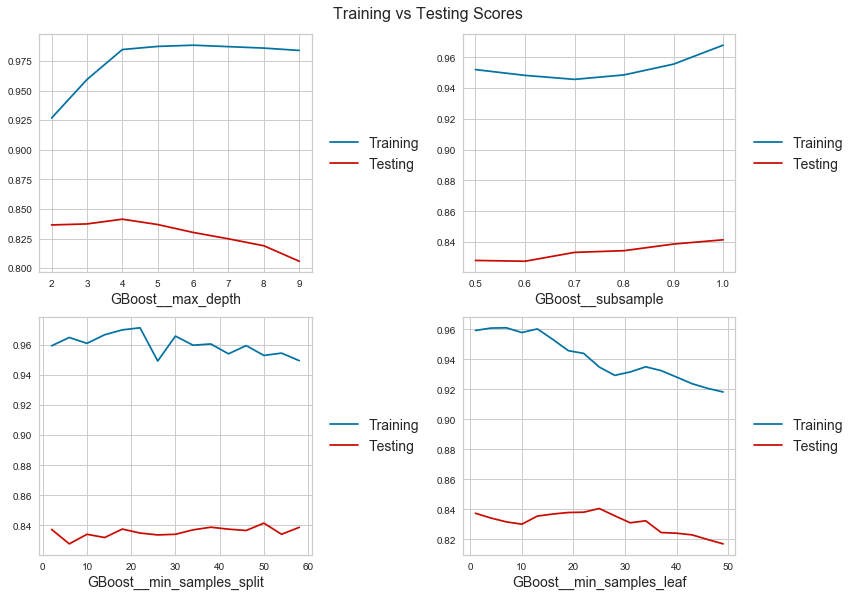

In [62]:
# plotting the training and testing scores as we iterate through different values for each parameter
mod.param_tuning_plots(smote_gboost_pipe, smote_gboost_param_grid, X_train, y_train, gs_kwargs,
                       n_cols=2, x_axis_log_scale=False, figsize=(12,8))

#### Observations from Training and Testing Scores

1. Similar to the ROS GBoost model, the model starts to __overfit__ as `maximum depth` __increases past 5__. The __optimal depth should be between 3 and 6__.
2. It appears that the optimal sampling proportion is arounf __90%-100%__ of our data.
3. For the `minimum samples to split` at each node, it the optimal value may lie somewhere __around 50__.
4. As for the `minimum samples per leaf node`, the optimal value is likely to be __between 20 and 30__.

From these observations, we can create a new subspace for our Grid Search.

In [63]:
# updating our search space
smote_gboost_param_grid = {
    'GBoost__max_depth' : np.arange(3, 6, step=1),
    'GBoost__subsample' : [0.90, 0.95, 1.0],
    'GBoost__min_samples_split' : np.arange(40, 60, step=2),
    'GBoost__min_samples_leaf' : np.arange(20, 30, step=1),
    'GBoost__max_features' : ['sqrt', None]
}

In [64]:
# grid search for the optimal hyper parameters
smote_gboost_gscv = GridSearchCV(smote_gboost_pipe, smote_gboost_param_grid, **gs_kwargs)
smote_gboost_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('SMOTE',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=8888, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('GBoost',
                                        GradientBoostingClassifie...
             iid='deprecated', n_jobs=-1,
             param_grid={'GBoost__max_depth': array([3, 4, 5]),
                         'GBoost__max_features': ['sqrt', None],
                         'GBoost__min_samples_leaf':

In [65]:
# optimal paramters for the SMOTE GBoost model
optimal_smote_params = dict((k[8:], smote_gboost_gscv.best_params_[k]) for k in smote_gboost_gscv.best_params_)
smote_gboost_kwargs = copy.deepcopy(baseline_gboost_kwargs)
smote_gboost_kwargs.update(optimal_smote_params)
smote_gboost_kwargs

{'learning_rate': 0.1,
 'n_estimators': 1000,
 'subsample': 0.95,
 'criterion': 'mse',
 'min_samples_split': 54,
 'min_samples_leaf': 23,
 'max_depth': 5,
 'random_state': 8888,
 'max_features': None,
 'verbose': 0,
 'validation_fraction': 0.1,
 'n_iter_no_change': 20,
 'ccp_alpha': 0.0}

#### Evaluating SMOTE impact on our Gradient Boosting Model

Holdout Dataset Classification Report for SMOTETunedGBoost
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       326
           1       0.87      0.77      0.82       155

    accuracy                           0.89       481
   macro avg       0.88      0.86      0.87       481
weighted avg       0.89      0.89      0.89       481




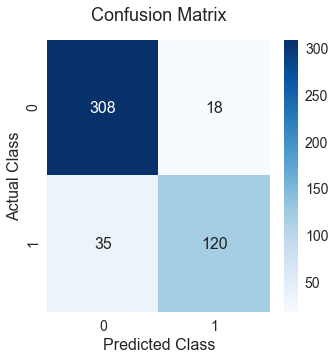

In [66]:
smote_tuned_gboost = smote_gboost_gscv.best_estimator_
smote_gboost_y_pred = mod.holdout_evaluation(smote_tuned_gboost, X_train, y_train, X_test, y_test,
                                             model_name='SMOTETunedGBoost')

In [67]:
smote_gboost_results = mod.classification_scores(y_test, smote_gboost_y_pred, model_name='SMOTETunedGBoost')
model_results = model_results.append(smote_gboost_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257
3,UntunedRForest,0.8503,0.7931,0.8673,0.6323,0.7313
4,RandomForest,0.8545,0.8148,0.8195,0.7032,0.7569
5,UntunedGBoost,0.8586,0.8128,0.8480,0.6839,0.7571
6,TunedGBoost,0.8836,0.8447,0.8837,0.7355,0.8028
7,ROSTunedGBoost,0.8919,0.8610,0.8759,0.7742,0.8219
8,SMOTETunedGBoost,0.8898,0.8595,0.8696,0.7742,0.8191


#### Model Performance Inference

Of the resampling methods that we have experimented with, Random Over Sampling has __improved the F1 Score by about 2%__. It has also __increased recall by around 4%__, at the expense of __slightly lowered precision__. 

Applying the SMOTE over sampling improved the F1 Score of the tuned gradient boosting model but has slightly poorer results thatn applying ROS to our data.

Therefore, the optimal model for making predictions is the __Tuned Gradient Boosting model with Random Over Sampling__ applied to our data. This will be the final pipeline that we use to make predictions for the test data.

In [68]:
# saving the best pipeline
best_model_pipeline = ros_tuned_gboost

# saving the model within the best pipeline
best_model = best_model_pipeline['GBoost']

with open('best_model_pipeline.pickle', 'wb') as f:
    pickle.dump(best_model_pipeline, f)

[Return to Table of Contents](#table_contents)

## Visualising Results

In this section, we want to __understand which features were deemed important__ by our model using visualisations.

We also want to visualise how our models perform in relation to one another.

### Feature Importance <a id='feature_importance'></a>

In [73]:
# saving the feature importances into a dataframe
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature' : X_train.columns.to_list(), 'Importance' : importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

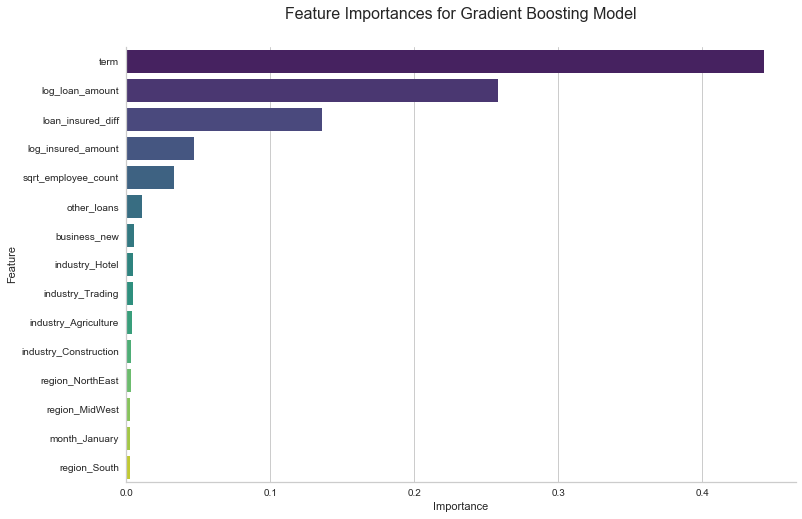

In [81]:
plt.figure(figsize=(12,8))
plt.title('Feature Importances for Gradient Boosting Model', size=16, y=1.05)

ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
sns.despine()
plt.show();

#### Analysis of Feature Importances

The dataset used to train our models had __44 features__ after one hot encoding our categorical features. Therefore, we decided to plot the __top 33%__ (~15) of our features in the figure above.

__Feature importance__ provides us information on which features were the __most useful when building our model__. 

Although we cannot make any interpretations on the dependence or correlation strength between each feature and default status, our results __mirror the correlation heatmap__ that we plotted in our exploratory data analysis. The __6 features with the highest correlation with default status__ have the __highest feature importances__ in our model as well. Therefore, we have some confidence that these features are useful for building our model due to their correlation with the target.

The success of our feature engineering is also evident, with our feature `loan_insured_diff` having the 3rd highest feature importance. 

Howeverm, our other feature `new_loans_2009` did not make the top 15 feature importances. 

__For future work__, we can apply the feature importances of the gradient boosting model to generate more features such as __interaction terms__ between the top 6 features. Subsequently, we can build a __logistic regression model__ to make inferences on how to __log-odds of default status changes depending on the feature__.

## Visualising Model Performance <a id='compare_models'></a>

In [89]:
melted_model_scores = pd.melt(
    model_results.drop(['Accuracy', 'ROC_AUC'], axis=1),
    id_vars='Model', var_name='Metric', value_name='Score'
)

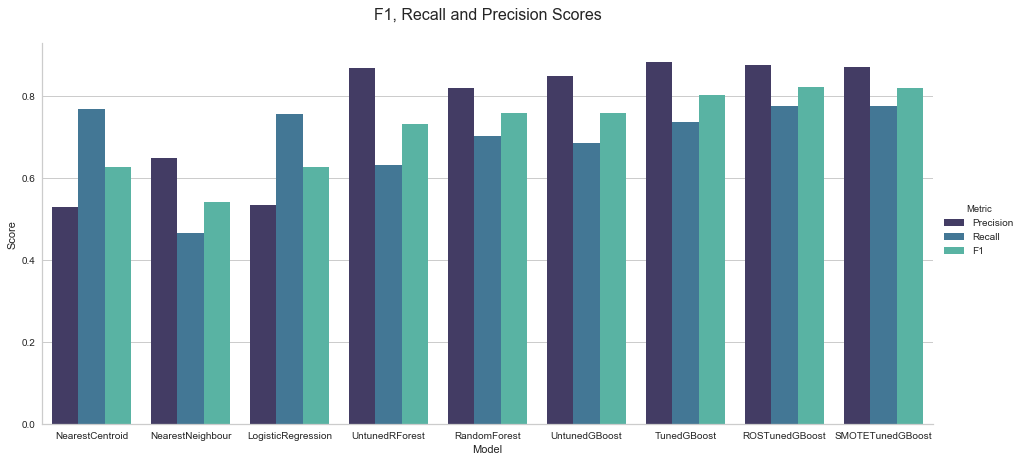

In [116]:
ax = sns.catplot(x='Model', y='Score', hue='Metric', data=melted_model_scores, kind='bar', palette='mako',
               height=6, aspect=2.2)
plt.title('F1, Recall and Precision Scores', y=1.05, size=16);

## Saving Hyper Parameters For All Models <a id='saving_params'></a>

In [117]:
model_names = ['NearestNeighbour', 'LogisticRegression', 'RandomForest', 'GBoost', 'ROS_GBoost', 'SMOTE_GBoost']
optimal_kwargs = [knn_kwargs, logreg_kwargs, rforest_kwargs, gboost_kwargs, ros_gboost_kwargs, smote_gboost_kwargs]

In [118]:
# Saving the models and their respective optimal hyper parameters
model_kwargs_optimal = pd.DataFrame({'Model' : model_names, 'OptimalParameters' : optimal_kwargs})

with open('optimal_hyper_params.pickle', 'wb') as f:
    pickle.dump(model_kwargs_optimal, f)

[Return to Table of Contents](#table_contents)